<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Exercises/11_td_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook pre steps

In [ ]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install dfply

from dfply import *
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import math
import random
from IPython.display import display, Markdown
# import json
# from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 14.3 MB/s eta 0:00:00


# Temporal difference methods for control

This notebook considers temporal difference (TD) and focuses on improving the policy (control) by applying generalised policy iteration (GPI). GPI repeatedly apply policy evaluation and policy improvement. Since we do not have a model (the transition probability matrix and reward distribution are not known), all our action-values are estimates. Hence, an element of exploration is needed to estimate the action-values.

We still consider the generic RL agent introduced when we did TD prediction.



In [ ]:
#@title Generic RL agent

import math  # math helpers
import random  # tie-breaking choices
from collections import defaultdict  # lazy nested dicts
from typing import Optional, List, Dict, Any  # typing

import numpy as np  # vector ops and RNG
import pandas as pd  # tabular data


try:
    from plotnine import ggplot, aes, geom_col, geom_tile, labs, theme_minimal  # plotting
except Exception:  # pragma: no cover
    ggplot = None  # fallback if plotnine isn't installed


class RLAgent:
    """
    Tabular RL agent with:
      - per-state action dictionaries {'q': value, 'n': visits}
      - behavior policy pi (dict action->prob)
      - state value v and state visit counter n

    Uses defaultdict so states/actions can be created lazily.
    """

    def __init__(self) -> None:
        # model[state] = dict with keys:
        #   'pi': policy dict(action->prob)
        #   'v': state value
        #   'n': state visit count
        #   'actions': dict(action -> {'q': float, 'n': int})
        self.model: Dict[str, Dict[str, Any]] = defaultdict(
            lambda: {
                "pi": None,     # policy probabilities
                "v": float("nan"),  # state value
                "n": 0,         # state visits
                "actions": defaultdict(lambda: {"q": 0.0, "n": 0}),  # actions
            }
        )  # core store

    # ----------------------------- helpers ------------------------------------

    def add_states(self, states: List[str]) -> None:
        """Force creation of states (defaultdict makes them auto-create)."""  # eager create
        for s in states:
            _ = self.model[str(s)]  # touch to ensure creation

    def add_state_action(self, s: str, a: str) -> None:
        """Ensure a state and a specific action exist."""  # lazy create
        _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_actions(self, s: str, actions: List[str]) -> None:
        """Force creation of actions in state s."""  # batch add
        for a in actions:
            _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_states_and_actions(self, df: pd.DataFrame) -> None:
        """Bulk add (state, action) pairs from DataFrame with columns 's' and 'a'."""  # bulk
        for s, a in zip(df["s"].astype(str), df["a"].astype(str)):
            _ = self.model[s]["actions"][a]  # touch-create

    # ----------------------------- setters ------------------------------------

    def set_action_value(self, value: float = 0.0) -> None:
        """Set q(s,a) to constant for all actions."""  # initializer/reset
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["q"] = float(value)  # assign

    def set_state_value(self,
                        states: Optional[List[str]] = None,
                        value: float = 0.0) -> None:
        """Set v(s) for given states (all if None)."""  # V setter
        states = states or list(self.model.keys())
        for s in states:
            self.model[s]["v"] = float(value)  # assign

    def set_action_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all action counters to ctr_value."""  # reset N(s,a)
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["n"] = int(ctr_value)  # assign

    def set_state_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all state visit counters to ctr_value."""  # reset N(s)
        for s in self.model:
            self.model[s]["n"] = int(ctr_value)  # assign

    def set_action_value_single(self,
                                s: str,
                                a: str,
                                value: float = 0.0,
                                ctr_value: int = 0) -> None:
        """Set q(s,a) and n(s,a) for a single state-action."""  # direct set
        _ = self.model[str(s)]["actions"][str(a)]  # ensure exists
        self.model[s]["actions"][a]["q"] = float(value)  # set q
        self.model[s]["actions"][a]["n"] = int(ctr_value)  # set n

    def set_random_eps_greedy_policy(self, eps: float) -> None:
        """Set π(s) to random ε-greedy (random greedy action per state)."""  # init π
        for s in self.model:
            actions = list(self.model[s]["actions"].keys())  # available actions
            if not actions:
                self.model[s]["pi"] = None  # no policy if no actions
                continue  # skip
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat
            a_star = random.choice(actions)  # random greedy pick
            pi[a_star] += 1.0 - eps  # exploitation bump
            self.model[s]["pi"] = pi  # store

    def set_eps_greedy_policy(self, eps: float, states: List[str] | str) -> None:
        """
        Make policy epsilon-greedy w.r.t current q-values.
        """
        states_list = [states] if isinstance(states, str) else list(states)
        for s in states_list:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-vector
            max_mask = q_vals == q_vals.max()  # tie mask
            idx = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat init
            pi[actions[idx]] += 1.0 - eps  # greedy bump
            self.model[s]["pi"] = pi  # assign

    def set_greedy_policy(self, states: Optional[List[str]] = None) -> None:
        """Set greedy deterministic policy from q-values."""  # greedy π
        states = states or list(self.model.keys())
        for s in states:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = [self.model[s]["actions"][a]["q"] for a in actions]  # q list
            best = actions[int(np.argmax(q_vals))]  # greedy idx
            self.model[s]["pi"] = {best: 1.0}  # point mass

    def set_policy(self, states: List[str], pi: Dict[str, float]) -> None:
        """Set π(s) explicitly for each s in states (probabilities need not be normalized)."""  # explicit π
        total = sum(pi.values())  # sum
        norm = {a: (p / total) for a, p in pi.items()} if total > 0 else {a: 0.0 for a in pi}  # normalize
        for s in states:
            self.model[s]["pi"] = dict(norm)  # copy in

    # ----------------------------- getters ------------------------------------

    def get_info(self):
        """
        Returns information about the agent.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_state_keys(self) -> List[str]:
        return list(self.model.keys())  # all states

    def get_action_keys(self, s: str) -> List[str]:
        return list(self.model[s]["actions"].keys())  # actions in s

    def get_action_info(self, s: str) -> Dict[str, Dict[str, Any]]:
        """Return shallow copy of the actions dict for state s."""  # inspection
        return dict(self.model[s]["actions"])  # shallow copy

    def get_state_value_q(self, s: str) -> float:
        """Compute v_pi(s) = sum_a pi(a|s) q(s,a)."""  # V from Q & π
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"]
                         for a, p in pi.items()))  # dot product

    def get_state_values(self,
                         states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame of (state, v). Uses dfply::mutate if available."""  # tidy
        states = states or list(self.model.keys())
        df = pd.DataFrame({"state": states})  # seed
        return pd.DataFrame({
            "state": states,
            "v": [self.model[s]["v"] for s in states],
        })  # basic

    def get_policy(self, states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame (state, action, pr) for current π."""  # tidy π
        states = states or list(self.model.keys())
        rows = []  # collect
        for s in states:
            pi = self.model[s]["pi"] or {}  # distribution
            for a, p in pi.items():
                rows.append({"state": s, "action": a, "pr": float(p)})  # row
        return pd.DataFrame(rows)  # frame

    def get_state_action_q_mat(self) -> pd.DataFrame:
        """Return wide Q-matrix DataFrame (rows=states, cols=actions)."""  # matrix
        states = list(self.model.keys())  # rows
        actions = sorted({a for s in states for a in self.model[s]["actions"].keys()})  # unique cols
        mat = pd.DataFrame(np.nan, index=states, columns=actions)  # init
        for s in states:
            for a, rec in self.model[s]["actions"].items():
                mat.loc[s, a] = rec["q"]  # fill
        return mat  # matrix

    def get_action_values(self,
                          states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return long-form DataFrame of q-values and counts."""  # tidy Q
        states = [states] if isinstance(states, str) else states
        states = states or list(self.model.keys())
        rows = []
        for s in states:
            for a, info in self.model[s]["actions"].items():
                rows.append({
                    "state": s,
                    "action": a,
                    "q": info["q"],
                    "n": info["n"],
                })
        return pd.DataFrame(rows)  # frame

    # ----------------------------- action selection ---------------------------

    def get_action_ucb(self, s: str, coeff: float = 1.0) -> Optional[str]:
        """UCB1-like selection; updates n(s) and n(s,a)."""  # UCB
        actions = list(self.model[s]["actions"].keys())  # available
        if not actions:
            return None  # no action
        self.model[s]["n"] += 1  # visit state
        qv = np.array([self.model[s]["actions"][a]["q"] for a in actions], dtype=float)  # q
        na = np.array([max(1, self.model[s]["actions"][a]["n"]) for a in actions], dtype=float)  # counts
        ns = float(self.model[s]["n"])  # state count
        bonus = coeff * np.sqrt(np.log(ns + 1e-4) / na)  # exploration term
        idx = int(np.argmax(qv + bonus))  # argmax
        a = actions[idx]  # pick
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_action_eg(self, s: str, eps: float) -> str:
        """Epsilon-greedy action selection (increments counters)."""  # ε-greedy
        self.model[s]["n"] += 1  # visit state
        actions = list(self.model[s]["actions"].keys())  # list
        q = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-values
        max_mask = q == q.max()  # ties
        idx_greedy = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
        probs = np.full(len(actions), eps / len(actions), dtype=float)  # base mass
        probs[idx_greedy] += 1.0 - eps  # greedy bump
        idx = int(np.random.choice(np.arange(len(actions)), p=probs))  # sample
        a = actions[idx]  # chosen action
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # return

    def get_action_pi(self, s: str) -> Optional[str]:
        """Sample an action from stored pi(a|s) (increments counters)."""  # sample π
        self.model[s]["n"] += 1  # visit state
        pi = self.model[s]["pi"] or {}  # distribution
        if not pi:
            return None  # no policy
        actions, probs = zip(*pi.items())  # unpack
        probs = np.array(probs, dtype=float)  # array
        probs /= probs.sum() if probs.sum() > 0 else 1.0  # normalize
        a = str(np.random.choice(list(actions), p=probs))  # draw
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_max_action_value(self, s: str) -> float:
        """Return max_a Q(s,a)."""  # convenience
        q = [rec["q"] for rec in self.model[s]["actions"].values()]  # list
        return float(max(q)) if q else float("nan")  # handle empty

    def get_exp_action_value(self, s: str) -> float:
        """Return E_{a~π}[Q(s,a)] under current π(s)."""  # expectation
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"] for a, p in pi.items()))  # dot

    # ----------------------------- learning -----------------------------------

    def policy_eval_td0(self,
                        env: Any,
                        gamma: float = 1.0,
                        alpha: float = 0.1,
                        max_e: int = 1000,
                        max_el: int = 10000,
                        reset: bool = True,
                        states: Optional[List[str]] = None) -> None:
        """
        TD(0) policy evaluation of V(s). The environment used must implement:
        get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env: Environment with get_time_step_data method.
            gamma: The discount factor.
            alpha: Step-size parameter
            max_e: Maximum number of iterations (episodes)
            max_el: Maximum episode length.
            reset: Reset action-values, state and action counters to 0.
            states: Starting states. For each iteration, generate
                an episode for each state. If `None` uses all states.
        """
        if reset:
            self.set_state_value(value=0.0)  # V=0
        starts = states or self.get_state_keys()  # candidate starts
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:  # no policy
                    break  # abort
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:  # terminal
                    break  # end
                old_v = self.model[s]["v"]  # current V
                td_target = r + gamma * self.model[sN]["v"]  # target
                self.model[s]["v"] = old_v + alpha * (td_target - old_v)  # update
                s = sN  # advance
            if i + 1 == max_el:  # cap hit
                break  # stop

    def policy_eval_mc(self,
                       env: Any,
                       gamma: float = 1.0,
                       theta: float = 0.1,
                       min_ite: int = 100,
                       max_ite: int = 2000,
                       reset: bool = True,
                       states: Optional[List[str]] = None,
                       verbose: bool = False) -> None:
        """
        Every-visit Monte Carlo evaluation of V(s).
        Env must implement: get_episode_pi(agent, s0) -> DataFrame with columns ['s','a','r'].  # contract
        """  # doc
        if reset:
            self.set_state_value(value=0.0)  # V=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        starts = states or self.get_state_keys()  # start set
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # max change
            for s0 in starts:  # episode per start
                df = env.get_episode_pi(self, s0)  # generate under π
                if df is None or len(df) == 0:
                    continue  # skip
                if verbose:
                    df['g'] = np.nan
                    df['n_s'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                g = 0.0  # return accumulator
                for i in range(len(df) - 1, -1, -1):  # reverse pass
                    s = str(df.iloc[i]["s"])  # state
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    n_s = max(1, self.model[s]["n"])  # denom
                    old_v = self.model[s]["v"]  # prev
                    step = 1.0 / n_s  # 1/N schedule
                    self.model[s]["v"] = old_v + step * (g - old_v)  # update
                    delta = max(delta, abs(old_v - self.model[s]["v"]))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_s"] = n_s
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = self.model[s]["v"]
                if verbose:
                    print("Episode:")
                    print(df)  # trace
            if delta < theta and ite >= min_ite:  # convergence
                break  # stop
        if ite == max_ite:
            print(f"Policy eval algorithm stopped at max iterations allowed: {max_ite}")  # warn
        print(f"Policy eval algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_mc(self,
                         env: Any,
                         gamma: float = 1.0,
                         theta: float = 0.1,
                         min_ite: int = 100,
                         max_ite: int = 1000,
                         reset: bool = True,
                         states: Optional[List[str]] = None,
                         eps: float = 0.1,
                         verbose: bool = False) -> None:
        """
        On-policy GPI via Every-Visit MC control on Q(s,a).
        Env must implement: get_episode(agent, s0, eps) -> DataFrame ['s','a','r']
        and update visit counters.

        Args:
            env (Any): Environment with get_episode method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            theta (float, optional): Convergence threshold. Defaults to 0.1.
            min_ite (int, optional): Minimum number of iterations. Defaults to 100.
            max_ite (int, optional): Maximum number of iterations. Defaults to 1000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episiode for each state. If `None uses all states.
            eps (float, optional): Epsilon for eps-greedy policy. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # track |ΔV|
            for s0 in starts:  # episode per start
                df = env.get_episode(self, s0, eps)  # behavior inside env
                if verbose:
                    df['g'] = np.nan
                    df['n_sa'] = np.nan
                    df['old_q'] = np.nan
                    df['step'] = np.nan
                    df['new_q'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                if df is None or len(df) == 0:
                    continue  # skip
                g = 0.0  # return
                for i in range(len(df) - 1, -1, -1):  # reverse sweep
                    s = str(df.iloc[i]["s"])  # state
                    a = str(df.iloc[i]["a"])  # action
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    # step size: (1 / n_sa) ** 0.5 as in R  # schedule
                    n_sa = max(1, self.model[s]["actions"][a]["n"])  # visits
                    old_q = self.model[s]["actions"][a]["q"]  # prev Q
                    old_v = self.get_state_value_q(s)  # V before update
                    step = (1.0 / n_sa) ** 0.5  # step-size
                    new_q = old_q + step * (g - old_q)  # MC update
                    self.model[s]["actions"][a]["q"] = new_q  # MC update
                    self.set_eps_greedy_policy(eps, [s])  # improve π(s)
                    new_v = self.get_state_value_q(s)  # V after
                    delta = max(delta, abs(old_v - new_v))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_sa"] = n_sa
                        df.at[i,"old_q"] = old_q
                        df.at[i,"step"] = step
                        df.at[i,"new_q"] = new_q
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = new_v
                if verbose:
                    print("Episode:")
                    print(df)

            if delta < theta and ite >= min_ite:
                break  # stop
        if ite == max_ite:
            print(f"GPI algorithm stopped at max iterations allowed: {max_ite}")
        print(f"GPI algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_sarsa(self,
                            env: Any,
                            gamma: float = 1.0,
                            max_e: int = 1000,
                            max_el: int = 10000,
                            reset: bool = True,
                            states: Optional[List[str]] = None,
                            eps: float = 0.1,
                            alpha: float = 0.1,
                            verbose: bool = False) -> None:
        """
        On-policy SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        if verbose:
            print(f"Start GPI/SARSA with max episode length {max_el}:")
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # pick start
            a = self.get_action_pi(s)  # first action under π
            for i in range(max_el):  # steps
                if a is None:
                    break  # no action available
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                aN = self.get_action_pi(sN)  # next action
                old_q = self.model[s]["actions"][a]["q"]  # current
                target = r + gamma * (self.model[sN]["actions"][aN]["q"] if aN is not None else 0.0)  # SARSA target
                self.model[s]["actions"][a]["q"] = old_q + alpha * (target - old_q)  # update
                if verbose:
                    print(f"(s,a,r+,s+,a+) = ({s}, {a}, {r}, {sN}, {aN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # local improve
                s, a = sN, aN  # advance
            if i + 1 == max_el:
                break  # hit max length of an episode, i.e. no episodes and stop
        print("GPI/SARSA finished.")  # info

    def gpi_off_policy_q_learning(self,
                                  env: Any,
                                  gamma: float = 1.0,
                                  max_e: int = 1000,
                                  max_el: int = 10000,
                                  reset: bool = True,
                                  states: Optional[List[str]] = None,
                                  eps: float = 0.1,
                                  alpha: float = 0.1,
                                  verbose: bool = False) -> None:
        """
        Off-policy Q-learning with behavior π_ε and greedy target.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # behavior π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # behavior action
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                q_next = [rec["q"] for rec in self.model[sN]["actions"].values()]  # next Qs
                max_q = max(q_next) if q_next else 0.0  # greedy target
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * max_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r+,s+) = ({s}, {a}, {r}, {sN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']} (maxQ={max_q})")  # trace
                self.set_eps_greedy_policy(eps, [s])  # refresh behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        self.set_greedy_policy()  # finalize with greedy π
        print("GPI/Q-learning finished.")  # info


    def gpi_on_policy_exp_sarsa(self,
                                env: Any,
                                gamma: float = 1.0,
                                max_e: int = 1000,
                                max_el: int = 10000,
                                reset: bool = True,
                                states: Optional[List[str]] = None,
                                eps: float = 0.1,
                                alpha: float = 0.1,
                                verbose: bool = False) -> None:
        """
        On-policy Expected SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                exp_q = self.get_exp_action_value(sN)  # expectation under π(sN)
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * exp_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN) = ({s}, {a}, {r}, {sN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']} (expQ={exp_q})")  # trace
                self.set_eps_greedy_policy(eps, [s])  # improve behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        print("GPI/Expected-SARSA finished.")  # info

In this notebook we need to pay attention to methods `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` that are implementations of the TD(0) control algorithms in [Module 11](https://bss-osca.github.io/rl/11_td-control.html). Note that for using the GPI algorithms in the agent class we need a method `get_time_step_data` that given a state and action return the reward and the next state.

## Exercises


###  Exercise - Factory Storage

Consider [Example 8.8](https://bss-osca.github.io/rl/08_dp.html#sec-dp-storage). An MDP model was formulated and solved using policy iteration. Our goal here is to solve the same problem with GPI using TD. For this we need an environment representing the problem:



In [ ]:
#@title Factory environment

import math
import random

class RLEnvFactory:
    """
    RL environment for a simple factory waste-accumulation process.

    States:
        "0", "1", "2", "3", "4"  (strings)

    Actions:
        - In state "0": only "keep"
        - In states "1".."4": "empty" or "keep"

    Dynamics:
        - Waste increments are random in {0,1,2,3} with probabilities `pr`.
        - Action "empty": reward = -(25 + 5 * s), next state sampled in {0..3}.
        - Action "keep": next state = s + sampled increment; if it exceeds 4,
          clamp to 4 and give overflow penalty -30 per unit above 4.

    Notes:
        - Rewards are floats; states are returned as strings.
        - No terminal states; every step returns a next state.
    """

    def __init__(self, pr=None, seed=None):
        """
        Initialize the environment.

        Args:
            pr: Probabilities for increments {0, 1, 2, 3}. If None, defaults to
                [1/8, 1/2, 1/4, 1/8].
            seed: Optional seed for reproducibility.
        """
        self.pr = pr if pr is not None else [1 / 8, 1 / 2, 1 / 4, 1 / 8]
        if any(p < 0 for p in self.pr):
            raise ValueError("Probability vector 'pr' must be non-negative.")
        if not math.isclose(sum(self.pr), 1.0, rel_tol=0, abs_tol=1e-12):
            raise ValueError("Probability vector 'pr' must sum to 1.")
        self.rng = random.Random(seed)

    def get_states(self):
        """
        Return all state keys.

        Returns:
            List of state labels as strings: ["0", "1", "2", "3", "4"].
        """
        return [str(i) for i in range(5)]

    def get_actions(self, s):
        """
        Return available actions for a given state.

        Args:
            s: Current state label (string).

        Returns:
            For state "0": the string "keep".
            For states "1".."4": the list ["empty", "keep"].
        """
        if s == "0":
            return "keep"
        return ["empty", "keep"]

    def get_time_step_data(self, s, a):
        """
        One-step transition: compute reward and next state.

        Args:
            s: Current state label (string).
            a: Action label. Must be "empty" or "keep" (or "keep" in state "0").

        Returns:
            Dict with:
              - 'r': float reward
              - 'sN': next state label (string)

        Raises:
            ValueError: if the (state, action) pair is invalid.
        """
        try:
            s_num = int(s)
        except Exception as exc:
            raise ValueError(f"State must be an integer-like string, got {s!r}.") from exc

        if s_num < 0 or s_num > 4:
            raise ValueError(f"State must be in ['0'..'4'], got {s!r}.")

        # Sample an increment in {0,1,2,3} using probability vector pr
        inc = self.rng.choices([0, 1, 2, 3], weights=self.pr, k=1)[0]

        if a == "empty":
            reward = -(25.0 + 5.0 * s_num)
            next_state = self.rng.choices([0, 1, 2, 3], weights=self.pr, k=1)[0]
            return {"r": float(reward), "sN": str(next_state)}

        if a == "keep":
            s_next = s_num + inc
            reward = 0.0
            if s_next > 4:
                overflow = s_next - 4
                reward = -30.0 * float(overflow)
                s_next = 4
            return {"r": float(reward), "sN": str(s_next)}

        raise ValueError("Error finding next state and reward: invalid action.")

Note that for using the GPI algorithms in the agent class, we need a method `get_time_step_data` that, given a state and action, returns the reward and the next state.

#### Q1

Consider the `get_time_step_data` method and explain what it does. Generate a reward and next state for $(s, a)$ pairs (0, keep), (4, keep) and (2, empty).


In [ ]:
#@title Solution

env = RLEnvFactory(seed=43)
# Your code

#### Q2

Consider the algorithms `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` that are implementations of the TD(0) control algorithms in [Module 11](https://bss-osca.github.io/rl/11_td-control.html) and try to identify the differences compared to the pseudo code descriptions. Why is expected SARSA here an on-policy algorithm?

<details>
   <summary>Solution</summary>
   In general, the algorithms use parameters `max_e` and `max_el` to identify the number of iterations, and the current policy is stored in `pi`. Moreover, `None` is used to identify the end of an episode (if returned from `get_time_step_data`). Expected SARSA is on-policy since use the $\epsilon$-greedy policy for updates.  
</details>




#### Define agent

In the following let us try to approximate the optimal policy using a discount factor of 0.5. The state-values for the optimal deterministic policy can be seen in [Example 8.8](https://bss-osca.github.io/rl/08_dp.html#sec-dp-storage).

We create an instance of the RL agent:

In [ ]:
# Build the agent and sync actions from the environment
agent = RLAgent()

# add states
agent.add_states(env.get_states())

# add actions per state (env returns a string for "0", list otherwise)
for s in agent.get_state_keys():
    actions = env.get_actions(s)
    if isinstance(actions, str):  # if only one action, then convert to list with one element
        actions = [actions]
    agent.add_actions(s, actions)

# inspect action info
print(agent.get_action_info("0"))
print(agent.get_action_info("4"))

#### Q3

Run methods `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` using `max_el = 5`, `alpha = 0.1` and `verbose = T`. Note, since the problem considers continuing tasks (no episodes), setting `max_el = 5` corresponds to calling `get_time_step_data` 5 times. Output action-values and the current policy. Explain the output.

In [ ]:
#@title Solution

print("SARSA:")
# Your code: agent.gpi_on_policy_sarsa(...)
display(agent.get_action_values())
display(agent.get_policy())

print("\nQ-learning:")
# Your code

print("\nExpected SARSA:")
# Your code

display(Markdown("""
Your comment
"""))

#### Q4

Run methods `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` using `max_el = 5000` and `alpha = 0.1`. Compare the policy and action-values against the state-values for the optimal deterministic policy found using the MDP:

```
MDP results
===========
Policy Iteration Results:
Optimal policy (0 = keep, 1 = empty): [0 0 0 0 1]
Value function: [-10.66265843 -16.32792889 -26.32610815 -41.97590748 -55.66265611]
Converged in iterations: 56
```


In [ ]:
#@title Solution

ite = 5000
mdp_v = [-10.66265843 -16.32792889 -26.32610815 -41.97590748 -55.66265611]

# Your code: agent.gpi_on_policy_sarsa(...)
display(agent.get_action_values() >> left_join(agent.get_policy()))

# Your code

# Your code

display(Markdown("""
Your comment
"""))

#### Q5

Run the algorithm `gpi_off_policy_q_learning` using `gamma = 0.99`, `maxEL = 5000, 10000 and 20000`. Compare the policy and action-values against the state-values for the optimal deterministic policy found using the MDP:

```
MDP results:
============
Optimal policy (gamma = 0.99): (0, 0, 0, 1, 1)
Value function: [-1749.6352341371678, -1761.994297682444, -1775.6094397390264, -1789.635234137168, -1794.635234137168]
```

Comment on your results.

In [ ]:
#@title Solution

mdp_v = [-1749.6352341371678, -1761.994297682444, -1775.6094397390264, -1789.635234137168, -1794.635234137168]

# Your code

# Your code

# Your code

display(Markdown("""
Your comments
"""))

#### Q6

How will the alpha value affect the rate of convergence?

<details>
   <summary>Solution</summary>
   Small alpha resembles the sample average while a large alpha put a larger weight on the present observations. This may result in larger fluctations in action-value estimates.
</details>


###  Exercise - Car Rental

Consider the car rental problem in [Module 7](https://bss-osca.github.io/rl/07_mdp-2.html#sec-mdp-2-car) and [Module 8](https://bss-osca.github.io/rl/08_dp.html#sec-dp-rental). An MDP model was formulated and solved using policy iteration. Our goal here is to solve the same problem with GPI using TD.



#### Q1

Finish the code in the method `get_time_step_data` of the environment representing the problem, and test your `get_time_step_data` method.



In [ ]:
#@title Solution

import numpy as np


class RLEnvCar:
    """
    Car rental environment (two locations) with Poisson demand/returns.

    States:
        Strings of the form "x,y" where x,y ∈ {0, …, 20} denote the number of
        cars available at location 1 and 2 at the start of a day.

    Actions:
        Move a cars overnight from location 1 → 2 (a > 0) or 2 → 1 (a < 0).
        The feasible action set for state (x, y) is:
            a ∈ [ -min(5, y, 20 - x),  min(5, x, 20 - y) ]  (integers)
        i.e., you can move at most 5 cars and cannot exceed capacity 20 at either site.

    Dynamics (per step):
        1) Apply action a: cars become x_bar = x - a, y_bar = y + a.
        2) Demand at site i ~ Poisson(lD[i]); fulfilled up to available cars.
        3) Returns at site i ~ Poisson(lH[i]); add to remaining cars.
        4) Cap each site at 20 cars.

    Reward:
        +10 for each rental fulfilled at either site, minus a movement cost
        of 2 per car moved:  r = 10 * (served_x + served_y) - 2 * |a|.

    Notes:
        - No terminal states; always returns a next state.
        - Randomness comes from Poisson draws; set `seed` in __init__ for reproducibility.
    """

    def __init__(self, lD = [3, 4], lH = [3, 2], seed = None):
        """
        Initialize the environment.

        Args:
            lD: Mean demand rates [λ1, λ2] for locations 1 and 2.
                Defaults to [3, 4].
            lH: Mean return rates [λ1, λ2] for locations 1 and 2.
                Defaults to [3, 2].
            seed: Optional integer seed for the RNG.
        """
        self.lD = list(lD)
        self.lH = list(lH)
        self.rng = np.random.default_rng(seed)

    def get_states(self):
        """
        Return all state keys.

        Returns:
            List of "x,y" strings for x,y in 0..20.
        """
        return [f"{x},{y}" for x in range(21) for y in range(21)]

    def get_actions(self, s):
        """
        Return all feasible actions (as strings) for a given state.

        Args:
            s: State label "x,y".

        Returns:
            List of integer actions encoded as strings.
        """
        x_str, y_str = s.split(",")
        x = int(x_str)
        y = int(y_str)

        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)
        return [str(a) for a in range(low, high + 1)]

    def get_time_step_data(self, s, a):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label "x,y".
            a: Action label as string (integer convertible).

        Returns:
            Dict with:
                - 'r': float reward.
                - 'sN': next state label "xN,yN".
        """
        x_str, y_str = s.split(",")
        x = int(x_str)
        y = int(y_str)
        a_int = int(a)

        # Validate action feasibility (optional but helpful)
        feasible = set(self.get_actions(s))
        if str(a_int) not in feasible:
            raise ValueError(f"Action {a_int} not feasible in state {s}. Feasible: {sorted(feasible)}")

        # Apply move
        x_bar = # Your code
        y_bar = # Your code

        # Sample demands and returns
        d_x = int(self.rng.poisson(self.lD[0]))
        d_y = int(self.rng.poisson(self.lD[1]))
        h_x = int(self.rng.poisson(self.lH[0]))
        h_y = int(self.rng.poisson(self.lH[1]))

        # Rentals served
        served_x = # Your code
        served_y = # Your code

        # Cars remaining after rentals, then returns, then cap at 20
        x_next = # Your code
        y_next = # Your code

        # Reward: rental revenue minus movement cost
        reward = 10.0 * (served_x + served_y) - 2.0 * abs(a_int)

        return {"r": float(reward), "sN": f"{x_next},{y_next}"}



In [ ]:
## Test environment

env = RLEnvCar(seed = 435)
print("First 5 states:", env.get_states()[:5])
print("Actions possible for state (10,2):", env.get_actions("10,2"))
print(env.get_time_step_data("0,0", "0"))       # zero cars at location 1 and 2. Move zero.
print(env.get_time_step_data("4,20", "-5"))     # 4 cars at l1, 20 at l2. Move 5 from l2 to l1.
# print(env.get_time_step_data("20,20", "14"))    # Raise ValueError - 20 cars at l1 and l2. Move 14 from l1 to l2.

#### Q2

Create the agent and run the methods `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` using a few iterations with a discount rate $\gamma = 0.5$, `verbose = T` and explain the output.



In [ ]:
#@title Solution

agent = RLAgent()
agent.add_states(env.get_states())
for s in agent.get_state_keys():
    actions = env.get_actions(s)
    if isinstance(actions, str):
        actions = [actions]
    agent.add_actions(s, actions)

print("SARSA:")
# Your code: agent.gpi_on_policy_sarsa(...)
display(agent.get_action_values() >> left_join(agent.get_policy()))

print("\nQ-learning:")
# Your code

print("\nExpected SARSA:")
# Your code

display(Markdown("""
Your comments
"""))

#### Q3

Run the methods `gpi_on_policy_sarsa`, `gpi_off_policy_q_learning` and `gpi_on_policy_exp_sarsa` with a discount rate $\gamma = 0.5$ using a high number of iterations, e.g. 25000, 50000 and 100000. Compare the policy with the optimal deterministic policy found using the MDP (see next cell). This can be done by making a plot of the estimated policy with:

- Values $y$ on the y-axis and $x$ on the x-axis.
- Colour points depending on whether they are equal to the optimal MDP action.
- Size of points equal the number of times the state has been visited.
- Text equals the action in black.
- A subplot for each algorithm and iterations (facet).
- The size of the plot can be set using e.g. `theme(figure_size=(10,10))`

Comment on the plot.


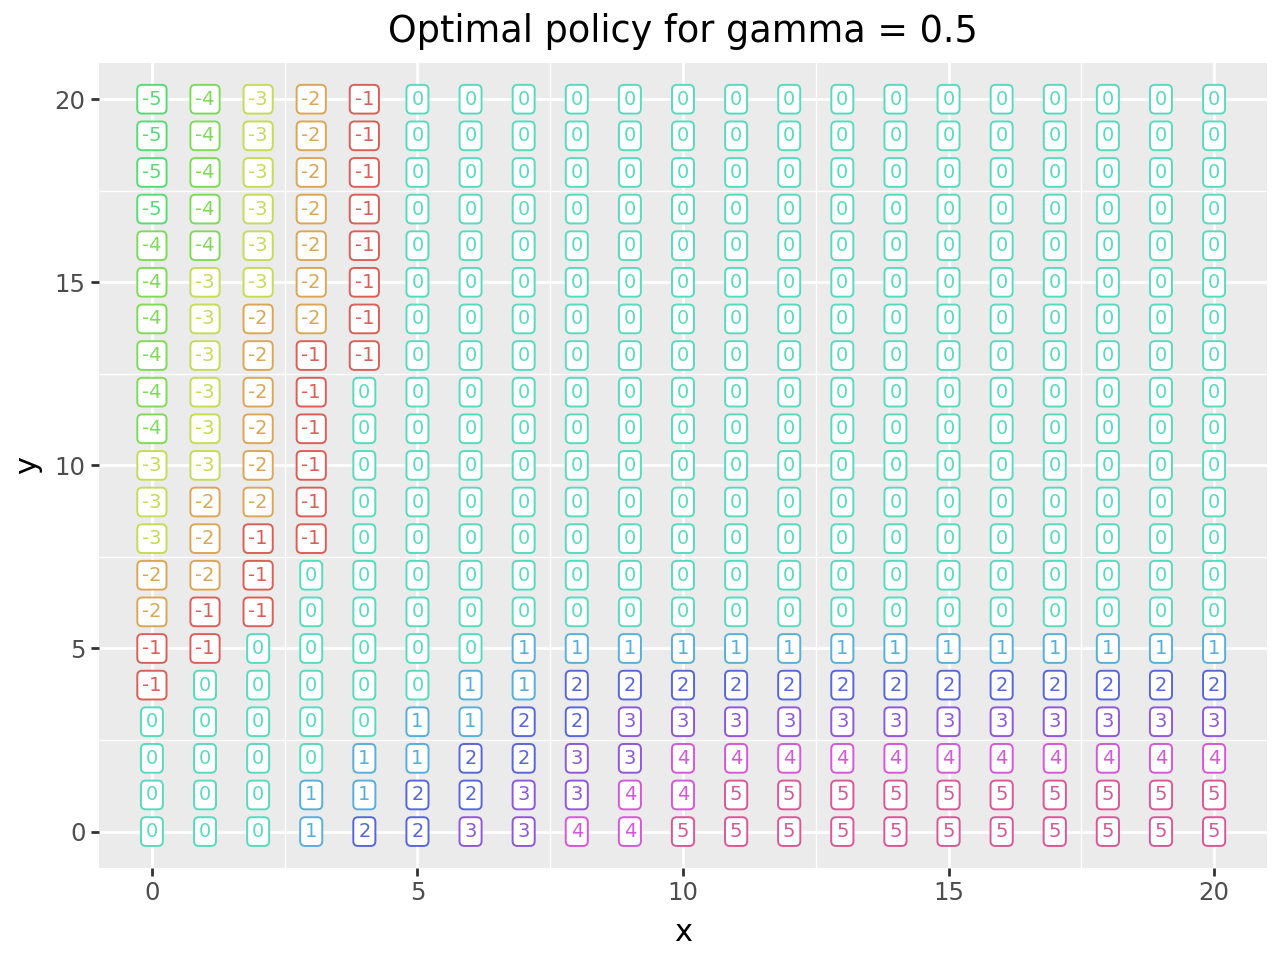</img>

In [ ]:
#@title Solution

# Load MDP policy
df_mdp_05 = pd.read_csv('https://drive.google.com/uc?id=1erY9kMgquTG1DBXIEKrRKNCyT5pFBAqO', index_col = False)
df_mdp_05

def _as_list(x):
    """Normalize scalars to single-element lists."""
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    return [x]

def run_alg(max_el, gamma, alpha, eps, sarsa=True, exp_sarsa=True, qlear=True, **kwargs):
    """
    Run RL control algorithms over parameter grids and collect results.

    Args:
        max_el: int or list of ints; episode length(s) per iteration.
        gamma: float or list of floats; discount(s).
        alpha: float or list of floats; learning rate(s).
        eps: float or list of floats; epsilon(s) for epsilon-greedy behavior.
        sarsa, exp_sarsa, qlear: toggles for which algorithms to run.

    Returns:
        DataFrame with columns:
            ['x','y','a','n','alg','q','iterations','gamma','alpha','eps']
        filtered to rows with n > 0.
    """
    df_rl = pd.DataFrame()
    for ite in _as_list(max_el):
        for gam in _as_list(gamma):
            for alph in _as_list(alpha):
                for e in _as_list(eps):
                    def _get_results(name):
                        """
                        Return the results of running an algorithm (SARSA, Q-learning, etc.)
                        """
                        res = (
                            agent.get_action_values()
                            >> left_join(agent.get_policy())
                            >> separate(X.state, into = ["x", "y"], sep = ",", remove = False, convert = True)
                            >> mutate(
                                label=f"{name} ite = {ite} gam = {gam} alpha = {alph} eps = {e}",
                                alg=name,
                                iterations=ite,
                                gamma=gam,
                                alpha=alph,
                                eps=e
                            )
                            >> group_by(X.state)
                            >> mutate(n_s = X.n.sum(), q_max=colmax(X.q))
                            >> mask(X.q == X.q_max)
                            >> row_slice(0)
                            >> left_join(df_mdp_05)
                        )
                        return(res)

                    if sarsa:
                        # Your code: agent.gpi_on_policy_sarsa(___)
                        res = _get_results("SARSA")
                        df_rl = df_rl >> bind_rows(res)
                    if exp_sarsa:
                        # Your code
                    if qlear:
                        # Your code
    df_rl = (df_rl
             >> ungroup()
             >> select(X.x, X.y, X.action, X.n_s, X.alg, X.q, X.iterations, X.gamma, X.alpha, X.eps, X.Policy, X.Value)
             >> mutate(optimal_a = (X.action.astype(int) == X.Policy.astype(int)))
             >> rename(a = X.action)
             >> mask(X.n_s > 0)
        )
    return df_rl

random.seed(9833)
np.random.seed(9833)
df_rl = run_alg(max_el=[25000, 50000, 100000], gamma=0.5, alpha=0.1, eps=0.1, sarsa=True, exp_sarsa=True, qlear=True, reset=True, verbose=False)
display(df_rl)

pt = (ggplot(df_rl, aes(x='x', y='y', color='optimal_a', size='n_s'))
     + ___
     + geom_text(aes(label='a'), size=5, color = "black")
     + facet_grid(___)
     + labs(title='Run with q=0 ini values')
     + theme(strip_text_x=element_text(size=5), figure_size=(10,10))
)
pt.show()

display(Markdown("""
Your comments
"""))

#### Q4

Consider Q-learning with 100000 iterations using the results from Q3. What is the optimal action in state $(2,2)$? What is the state-value in state $(2,2)$ and $(15,17)$, and its interpretation?



In [ ]:
#@title Solution

dat = (
    df_rl
        >> filter_by(
            (((X.x == 2) & (X.y == 2)) | ((X.x == ___) & (X.y == ___)))
            & (X.iterations == ___) & (X.alg == "___")
        )
)
val = dat['a'].values
display(dat)

display(Markdown(f"""
Your comments
"""))

#### Q5

Run the algorithm Q-learning with a discount rate $\gamma = 0.5$ and 100000 iterations. Test the effect of different epsilon-greedy behaviour policies, e.g. epsilon = 0.2, 0.5 and 1. Comment on your results.



In [ ]:
#@title Solution

df_rl_eps = run_alg(___)

pt = ___
)
pt.show()

display(Markdown(f"""
Your comments
"""))

#### Q6

Run the algorithm Q-learning with a discount rate $\gamma = 0.5$ and 100000 iterations. Test the effect of different step-sizes, e.g. alpha = 0.05, 0.2, 0.5. Comment on your results.



In [ ]:
#@title Solution

df_rl_alpha = run_alg(___)

pt = (___
)
pt.show()

## Weighted RMS
res = (df_rl_alpha
    >> group_by(X.iterations, X.alg, X.alpha, X.gamma, X.eps)
    >> summarize(rms=((X.n_s/100000) * ((X.q - X.Value) ** 2)).sum())
)
res['rms'] = [np.sqrt(x) for x in res['rms']]
display(res)


display(Markdown(f"""
Your comments
"""))